<a href="https://colab.research.google.com/github/roshansadath/100-Days-Of-ML-Code/blob/master/Simple%20Chest%20XRay/Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
%run "/content/drive/My Drive/Colab Notebooks/utils.ipynb"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
from torchvision.models.inception import InceptionOutputs

In [ ]:
data_path = "drive/My Drive/Simple_Chest_XRay/"
#data_path = "drive/My Drive/NIH_Chest_XRay/"
#data_path = "drive/My Drive/Harvard_Chest_XRay/"

sample_ratio = 1
batch_size = 64
num_epochs = 15

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

**DATA PREPROCESSING**


In [ ]:
def data_sampling(indices):
  return torch.utils.data.sampler.SubsetRandomSampler(indices)

In [ ]:
data_transforms = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Get dataset from folder and apply data transforms
dataset = datasets.ImageFolder(root = "{}data".format(data_path), transform = data_transforms)
  
# Get a sample of the data randomly
num_samples = int(len(dataset) * sample_ratio)
indices = np.random.choice(range(len(dataset)), num_samples, replace = False)

# Split the data into training, test, and validation sets
train_size = int(0.7 * num_samples)
test_size = int(0.2 * num_samples)
val_size = num_samples - train_size - test_size

train_indices = indices[ : train_size]
test_indices = indices[train_size : train_size + test_size]
val_indices = indices[train_size + test_size : ]

samples = [data_sampling(i) for i in [train_indices, test_indices, val_indices]]

# Create data loaders for training, test, and validation sets
train_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[0], num_workers = 4, pin_memory = True)
test_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[1], num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[2], num_workers = 4, pin_memory = True)

 **DOWNLOAD RESNET18 MODEL AND TRAIN**


In [ ]:
def save_metrics(loss, accuracy, model):
  np.save("{}{}_train_loss.npy".format(data_path, model), loss)
  np.save("{}{}_train_accuracy.npy".format(data_path, model), accuracy)

In [ ]:
# Define the ResNet18 model and set Pretraining to False to train model from scratch
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained = False)
#num_ftrs = model.fc.in_features
model.fc = nn.Linear(2048, len(dataset.classes))
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
losses, accuracies, true, pred, v_accuracies, v_losses = [], [], [], [], [], []

# Train model on training set
for epoch in range(num_epochs):
    train_loss, train_accuracy, start_time = 0.0, 0.0, time.time()

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
      for inputs, labels in train_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * inputs.size(0)
          train_accuracy += torch.sum(preds == labels.data)
          pred.extend(preds.cpu().numpy())
          true.extend(labels.cpu().numpy())
          
          pbar.set_postfix({'loss': loss.item()})
          pbar.update()

    train_loss /= len(train_indices)
    train_accuracy /= len(train_indices)
    _recall = recall_score(true, pred, average='macro')
    _precision = precision_score(true, pred, average='macro')
    _fscore = f1_score(true, pred, average='macro')

    print('Epoch: {} | Accuracy: {:.4f} | Loss: {:.4f} | Recall: {:.4f} | Precision: {:.4f} | F-Score: {:.4f} | Time: {:.4f}s'.format(epoch+1, train_accuracy, train_loss, _recall, _precision, _fscore, time.time() - start_time))
    val_accuracy, val_loss = evaluate_model(model, val_loader, val_indices, 'VALIDATION', criterion, data_path, "InceptionV3")
    v_accuracies.append(val_accuracy)
    v_losses.append(val_loss)
    losses.append(train_loss)
    accuracies.append(train_accuracy.item())

save_metrics(losses, accuracies, "InceptionV3")

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip


Epoch: 1 | Accuracy: 0.8831 | Loss: 0.2887 | Recall: 0.8467 | Precision: 0.8562 | F-Score: 0.8512 | Time: 4684.5017s
MODEL PERFORMANCE ON VALIDATION SET
Accuracy: 0.8311 | Loss: 0.6291 | Recall: 0.8786 | Precision: 0.7922 | F-score: 0.8070

Epoch: 2 | Accuracy: 0.8609 | Loss: 0.3218 | Recall: 0.8359 | Precision: 0.8406 | F-Score: 0.8382 | Time: 3905.0371s
MODEL PERFORMANCE ON VALIDATION SET
Accuracy: 0.9215 | Loss: 0.2357 | Recall: 0.8707 | Precision: 0.9119 | F-score: 0.8887

Epoch: 3 | Accuracy: 0.9200 | Loss: 0.2049 | Recall: 0.8583 | Precision: 0.8598 | F-Score: 0.8590 | Time: 3917.3159s
MODEL PERFORMANCE ON VALIDATION SET
Accuracy: 0.9659 | Loss: 0.1223 | Recall: 0.9563 | Precision: 0.9521 | F-score: 0.9542

Epoch: 4 | Accuracy: 0.9290 | Loss: 0.1778 | Recall: 0.8717 | Precision: 0.8724 | F-Score: 0.8721 | Time: 3914.6997s
MODEL PERFORMANCE ON VALIDATION SET
Accuracy: 0.9608 | Loss: 0.1176 | Recall: 0.9459 | Precision: 0.9480 | F-score: 0.9469

Epoch: 5 | Accuracy: 0.9366 | Loss: 

**SAVE MODEL PARAMETERS**

In [ ]:
torch.save(model.state_dict(), "{}inceptionv3.pth".format(data_path))

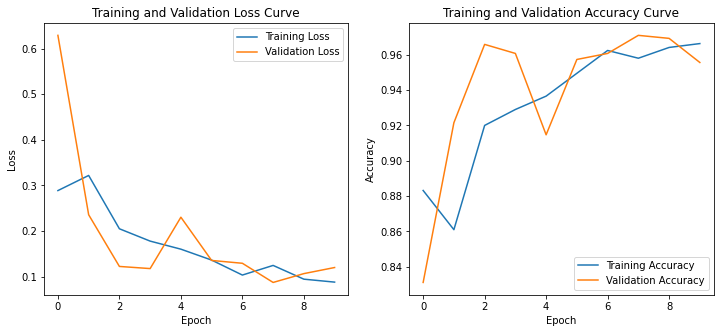

In [ ]:
#Plotting the Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(losses, label = "Training Loss")
ax1.plot(v_losses, label = "Validation Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Curve')
ax1.legend()

ax2.plot(accuracies, label = "Training Accuracy")
ax2.plot(v_accuracies, label = "Validation Accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Curve')
ax2.legend()

plt.show()

**EVALUATE MODEL ON VALIDATION AND TEST SET**

MODEL PERFORMANCE ON TEST SET
Accuracy: 0.9419 | Loss: 0.1491 | Recall: 0.9282 | Precision: 0.9248 | F-score: 0.9265



<Figure size 576x576 with 0 Axes>

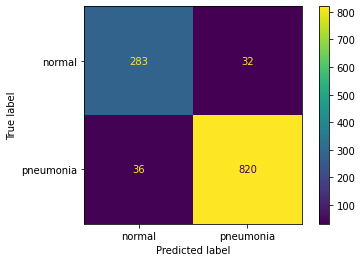

In [ ]:
#Evaluate Model on Test Set
evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "Inceptionv3")

In [ ]:
#Obtain the TSNE Plot for the data
features = []
labels = []
for images, targets in train_loader:
    with torch.no_grad():
        output = model(images)
        features.append(output.cpu().numpy())
        labels.append(targets.numpy())

features = np.vstack(features)
labels = np.concatenate(labels)

# Perform t-SNE on the feature vectors
tsne = TSNE(n_components=2, perplexity = 20, learning_rate = 600, n_iter = 900)
tsne_features = tsne.fit_transform(features)

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=plt.cm.get_cmap('jet', len(dataset.classes)))
plt.legend()
plt.title('t-SNE Plot')
plt.show()

In [ ]:
# Get the class labels and the number of classes
class_labels = dataset.classes
num_classes = len(class_labels)

# Get the number of images per class
num_images_per_class = []
for i in range(num_classes):
    class_indices = np.where(np.array(dataset.targets) == i)[0]
    num_images_per_class.append(len(class_indices))

# Compute the mean and variance of the images per class
mean_num_images = np.mean(num_images_per_class)
var_num_images = np.var(num_images_per_class)

# Plot the within-class variance
fig, ax = plt.subplots()
ax.bar(class_labels, num_images_per_class)
ax.axhline(y=mean_num_images, linestyle='--', color='r', label='Mean')
ax.axhspan(mean_num_images - np.sqrt(var_num_images), mean_num_images + np.sqrt(var_num_images),
           alpha=0.2, color='y', label='Variance')
ax.legend()
plt.xticks(rotation = 0)
plt.ylabel('Number of Images')
plt.xlabel('Class Labels')
plt.title('Within-Class Variance Plot')
plt.show()

In [ ]:
def within_class_variance(dataset, model):
    # Set the model to evaluation mode
    model.load_state_dict(model['model_state_dict'])
    model.eval()
    # Get the feature vectors and labels for the dataset
    features = []
    labels = []
    for images, targets in train_loader:
        with torch.no_grad():
          images = images.to(device)
          targets = targets.to(device)
          output = model(images)
          features.append(output.cpu().numpy()[0])
          labels.append(targets.cpu().numpy()[0])
    features = np.array(features)
    labels = np.array(labels)
    
    # Calculate the within-class variance for each class
    class_variances = []
    for c in np.unique(labels):
        class_features = features[labels == c]
        class_mean = np.mean(class_features, axis=0)
        class_variance = np.mean(np.sum((class_features - class_mean)**2, axis=1))
        class_variances.append(class_variance)
    
    return class_variances

# Define the dataset and model
# Calculate the within-class variance
class_variances = within_class_variance(dataset, model)

# Plot the within-class variances for each class
plt.bar(np.arange(len(class_variances)), class_variances)
plt.xticks(np.arange(len(class_variances)), dataset.classes, rotation='vertical')
plt.ylabel('Within-class variance')
plt.show()